<h1>Assignment on Panel Data:<\h1><br>
    Empirical Replication of Adema and Pozzi (2015)

In this assignment, we replicate and extend some of the empirical results in Adema and Pozzi (2015). 
The dataset together with the data description is provided on Canvas. 
In particular, we are interested in replicating the results in Tables 2-3 of that paper. 
Before proceeding with the tasks described in this section, `read carefully Adema and Pozzi (2015)`. 

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import random

We import CSV file and create three new RHS variables: two lags - $\Delta s_{i,t-1}$, $\Delta y_{i,t-1}$,  and one lead variable $\Delta y_{i,t+1}$. Notice that your LHS variable of interest is $\Delta s_{i,t}$.

In [5]:
sCol = ['ID', 'Time', 'DeltaS', 'DeltaY']
df = pd.read_csv('Data_Assignment.txt', delimiter = "\t",header=None,usecols=[0,1,2,9], names=sCol )
df['DeltaS_lag'] = df.groupby(['ID'])['DeltaS'].shift(1)
df['DeltaY_lag'] = df.groupby(['ID'])['DeltaY'].shift(1)
df['DeltaY_lead'] = df.groupby(['ID'])['DeltaY'].shift(-1)

As it is mentioned by the authors, for some countries data in the beginning of the sample is not available. To simplify your analysis, please consider only data from `1971-2012 for 14 countries`, i.e. drop Denmark and Ireland from your sample. Notice that because the empirical model has leads and lags of RHS variables the effective length of your panel variables is only $41+1-2=40$.

In [6]:
df = df.drop(df[df.ID==5].index)
df = df.drop(df[df.ID==9].index)
df = df.drop(df[df.Time <1972].index)
df = df.drop(df[df.Time >2011].index)

df

,ID,Time,DeltaS,DeltaY,DeltaS_lag,DeltaY_lag,DeltaY_lead
3,1,1972,0.010026,0.023169,0.021553,0.038489,0.043908
4,1,1973,0.020100,0.043908,0.010026,0.023169,0.015815
5,1,1974,0.004775,0.015815,0.020100,0.043908,0.023548
6,1,1975,0.002466,0.023548,0.004775,0.015815,0.039224
7,1,1976,-0.029913,0.039224,0.002466,0.023548,0.014483
...,...,...,...,...,...,...,...
698,16,2007,-0.003379,0.017899,0.007767,0.026667,-0.002906
699,16,2008,0.019948,-0.002906,-0.003379,0.017899,-0.028021
700,16,2009,0.011181,-0.028021,0.019948,-0.002906,0.025068
701,16,2010,-0.004909,0.025068,0.011181,-0.028021,0.018473


Can we learn anything from pooled regression of $\Delta s_{i,t}$ on $\Delta y_{i,t}$? Not really...

<AxesSubplot:xlabel='DeltaY'>

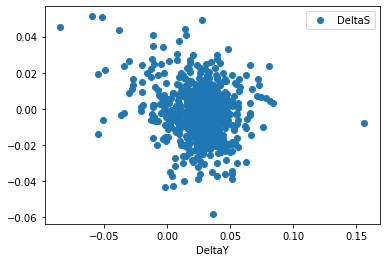

In [7]:
df.plot(x='DeltaY', y='DeltaS', style='o')

I find it useful to have all regressors in the format of an array $[K x T x N]$.

In [8]:
def PrepareData (df, iSizeN, iSizeT, sCol):
    
    mDataY  = np.transpose(np.asmatrix(df[sCol[0]].values).reshape(iSizeN,iSizeT))
    iSizeK = np.int(np.size(sCol)-1)
    
    aX = np.empty((iSizeK,iSizeT,iSizeN))

    for k in range (0,iSizeK):
        aX[k,:,:] = np.transpose(np.asmatrix(df[sCol[k+1]].values).reshape(iSizeN,iSizeT))
        
        
    return (mDataY,aX)

In [9]:
mDataY, aX = PrepareData (df, 14, 40, ['DeltaS','DeltaS_lag','DeltaY_lag','DeltaY','DeltaY_lead'])

You might also find useful to construct the orthogonal projection matrix $\boldsymbol{M_{F}=I-F(F'F)^{-1}F'}$ for any $[T x L]$ matrix $\boldsymbol{F}$. For example

In [10]:
def FETrans (mF):
    
    iSizeT = np.shape(mF)[0]

    return np.identity(iSizeT) - mF @ np.linalg.inv(mF.T@ mF/iSizeT)@ mF.T/iSizeT

Note that this approach is only applicable for balanced panels, where the elimination of unit-specific and time-specific additive effects can be expressed using these matrices. Alternatively, you can use groupby options and remove unit-specific and time-specific effects directly from the dataframe.

For the pooled estimator it is convenenient to transform $[K x T x N]$ array into a $[K x NT]$ matrix. The function below does this for you efficiently. For example, your pooled estimator can be expressed as $(X'X)^{-1}X'y$ where $X$ is a $[NT x K]$. Notice that this function also pre-multiplies every regressor by $\boldsymbol{M_{F}=I-F(F'F)^{-1}F'}$ first, before doing any manipulation. Time effects should be removed beforehand.

In [11]:
def FlatArray(aData, mF):
    
    iSizeK, iSizeT, iSizeN = np.shape(aData)
    iLength = int(iSizeT*iSizeN)
    aMultT = np.broadcast_to(mF,(iSizeK,)+mF.shape)
    aDataTrans = np.transpose(np.matmul(aMultT,aData),(0,2,1))
    
    return aDataTrans.reshape(iSizeK,iLength)

For Mean group estimators, you need individual specific coefficients $\hat{\theta}_{i}$. You can either do it by: a) looping over $[KxTx [i]]$ for all $i$ and then do unit-by-unit OLS; b) avoid loops and operate on arrays directly. The second option is much faster (of order >10 times faster) but is more difficult to program. Option b) is essentially required only if you want to do fancy bootstrap where coefficients need to be re-estimated $B$ times. This is not needed in your exercise

Finally, how can we efficiently remove time effects from a balanced panel?

In [9]:
# construct [N x N] matrix, where N=14
mTransN = FETrans(np.ones((14,1)))
# create [K x N x Na array where for every k=1,...,K you have mTransN as an input
aTransX = np.broadcast_to(mTransN,(int(np.shape(aX)[0]),)+mTransN.shape)
# pre-multiply every regressor from the right (i.e. the N dimension)
aX = np.matmul(aX,aTransX)

# the final result is a [K x T x N] array


You might also find this function useful when calculating Heteroscedasticity and autocorrelation robust S.E. (CCM estimator) for the FE estimator (with or without time-effects)

In [10]:
def FEScore (mF, mDataY, aX, vBeta):
    
    iSizeK, iSizeT, iSizeN = np.shape(aX)

    vBeta = np.array(vBeta)
    mTrans = FETrans(mF)
    mE = mDataY - np.sum(np.multiply(aX, vBeta.reshape(iSizeK,1,1)),axis=0)
    mE = mTrans@mE
    aE = np.broadcast_to(mE,(iSizeK,)+mE.shape)
    aW = np.multiply(aX,aE)

    return aW

This function creates a $[K x T x N]$ array with elements $w_{i,t}^{(k)}=x_{i,t}^{(k)}\widehat{\varepsilon}_{i,t}$. You can then use this input to calculate the CCM matrix estimator, using average over one of the dimension.